<a href="https://colab.research.google.com/github/mayukbasu/Amazon-Reviews/blob/main/Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
# For visualizations
import matplotlib.pyplot as plt
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math

In [ ]:
"!tar -xzvf amazon_review_full_csv.tgz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

In [ ]:
from google.colab import files 
uploaded = files.upload() 

In [ ]:
df = pd.read_csv("/content/1429_1.csv")
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [ ]:
print("Shape of data=>",df.shape)

Shape of data=> (34660, 21)


In [ ]:
df=df[['name','reviews.text','reviews.doRecommend','reviews.numHelpful']]
print("Shape of data=>",df.shape)
df.head(5)

Shape of data=> (34660, 4)


,name,reviews.text,reviews.doRecommend,reviews.numHelpful
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",This product so far has not disappointed. My c...,True,0.0
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",great for beginner or experienced person. Boug...,True,0.0
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Inexpensive tablet for him to use and learn on...,True,0.0
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I've had my Fire HD 8 two weeks now and I love...,True,0.0
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I bought this for my grand daughter when she c...,True,0.0


In [ ]:
df.isnull().sum()

name                   6760
reviews.text              1
reviews.doRecommend     594
reviews.numHelpful      529
dtype: int64

In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

name                   0
reviews.text           0
reviews.doRecommend    0
reviews.numHelpful     0
dtype: int64

In [ ]:
df=df.groupby('name').filter(lambda x:len(x)>500).reset_index(drop=True)
print('Number of products=>',len(df['name'].unique()))

Number of products=> 8


In [ ]:
df['reviews.doRecommend']=df['reviews.doRecommend'].astype(int)
df['reviews.numHelpful']=df['reviews.numHelpful'].astype(int)

# Cleaning Text Data in Python

In [ ]:
df['name'].unique()

array(['All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta',
       'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta',
       'Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue,,,',
       'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case',
       'Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,',
       'Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers,',
       'Echo (White),,,\r\nEcho (White),,,',
       'Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,'], dtype=object)

In [ ]:
df['name']=df['name'].apply(lambda x: x.split(',,,')[0])

In [ ]:
for index,text in enumerate(df['reviews.text'][35:40]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 I love everything about this tablet! The imaging is sharp and clear. It's fast and light weight. Love it!
Review 2:
 Overall a nice product for traveling purposes Value for money
Review 3:
 My children love this table great quality of pictures, excellent camera
Review 4:
 I bought 3 tablets and my family was not disappointed.
Review 5:
 Great tablet fast screen good size never gives me problem


# Expand Contractions

Contractions are the shortened versions of words like don’t for do not and how’ll for how will. These are used to reduce the speaking and writing time of words. We need to expand these contractions for a better analysis of the reviews.

Here, I have created a dictionary of common English contractions that I will use for mapping the contractions to their expanded forms:

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['reviews.text']=df['reviews.text'].apply(lambda x:expand_contractions(x))

# Lowercase the reviews

In [ ]:
df['cleaned']=df['reviews.text'].apply(lambda x: x.lower())

# Remove digits and words containing digits

In [ ]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

# Remove Punctuations

In [ ]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [ ]:
# Removing extra spaces
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
# Removing extra spaces
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

# Preparing Text Data for EDA

Stopwords Removal

Lemmatization

Create Document Term Matrix

In [ ]:
# Importing spacy
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [ ]:
df_grouped=df[['name','lemmatized']].groupby(by='name').agg(lambda x:' '.join(x))
df_grouped.head()

,lemmatized
name,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",product far disappoint child love use like abi...
Amazon Fire Tv,echo learn everyday use daily use place speake...
Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,nice little set slow wish investigate little j...
Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue,good value money hand work perfectly purchase ...
Echo (White),compete ipad high end android tablet easily ou...


In [ ]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index
df_dtm.head(3)

,aa,aaa,aamazon,abandon,abattery,abc,abcmouse,abcmousecom,abcs,abd,ability,abilty,abit,abke,able,abnormal,abode,abook,abound,abount,abouti,aboutif,abroad,abruptly,absence,absofbe,absoluitely,absolute,absolutely,absolutly,absorb,abt,abundance,abundant,abuse,ac,academic,acc,acce,accedently,...,youe,yougo,youit,youkathleen,younameit,young,younger,youngest,youngin,youngster,yourbedmate,youreyesprobably,yous,youse,youshe,youso,youth,youtube,youtubeand,youtubegmail,youtubekid,youtubenetflix,youtubepandora,youversion,youwhat,yr,yrold,yrs,yup,zeepad,zeppelin,zero,zigbee,zinio,zip,zippy,zone,zoo,zoom,zwave
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",0,0,0,0,0,0,0,0,0,0,24,0,1,0,77,0,0,0,0,1,0,0,0,0,0,0,0,3,33,0,0,0,0,0,2,0,0,1,1,0,...,0,0,0,0,0,20,0,0,0,0,0,1,0,0,0,0,1,37,0,0,0,0,0,0,0,23,0,3,0,0,0,4,0,1,0,0,0,0,0,0
Amazon Fire Tv,0,1,1,0,0,0,0,0,0,0,37,0,0,0,121,0,0,0,0,0,0,0,0,1,1,0,0,1,49,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,2,0,1,0,0,1,0,0,0,1,0,0,0,0,0
Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,0,0,0,1,0,2,0,0,0,0,56,0,0,0,131,1,0,1,1,0,0,0,0,0,0,0,0,1,69,0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,15,0,0,0,2,1,0,0,0,0,0,0,4,0,0,0,0,0,0,0,10,0,5,0,0,0,4,0,0,0,0,2,0,2,0


# Exploratory Data Analysis on Amazon Product Reviews

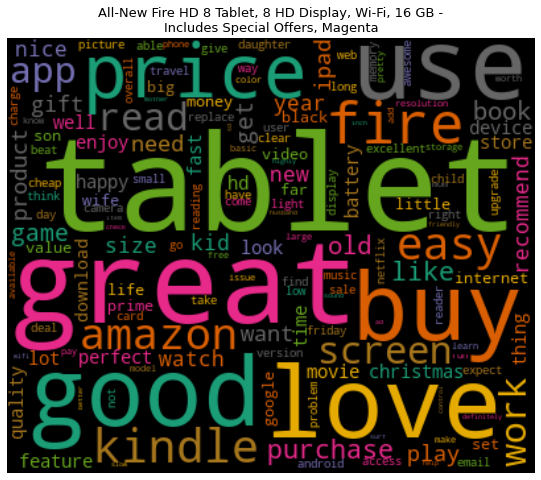

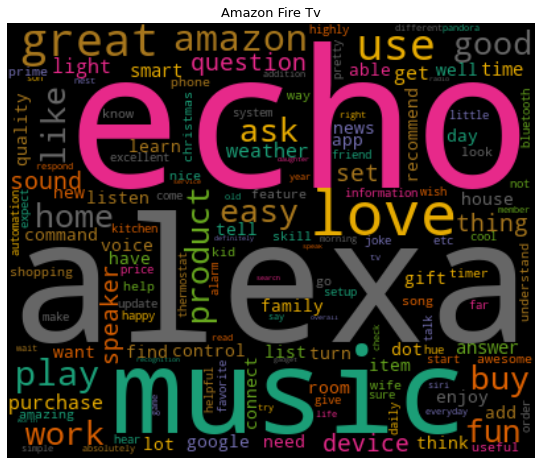

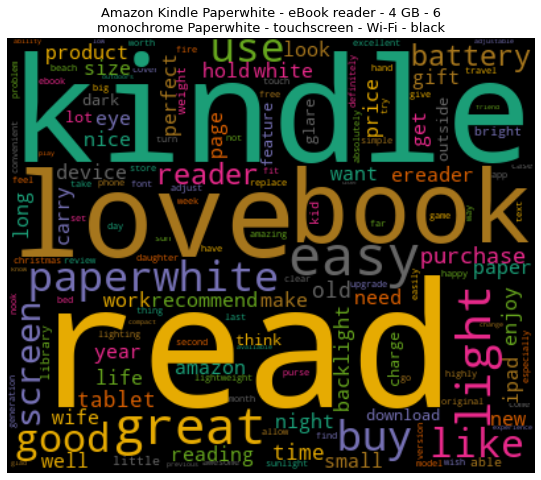

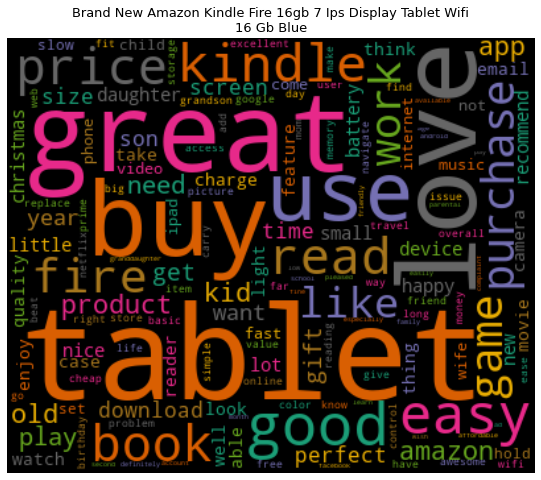

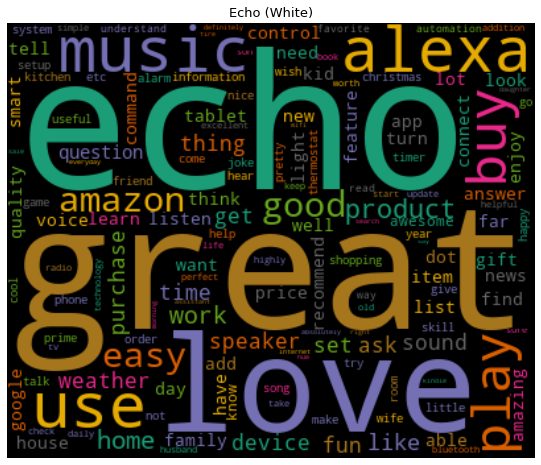

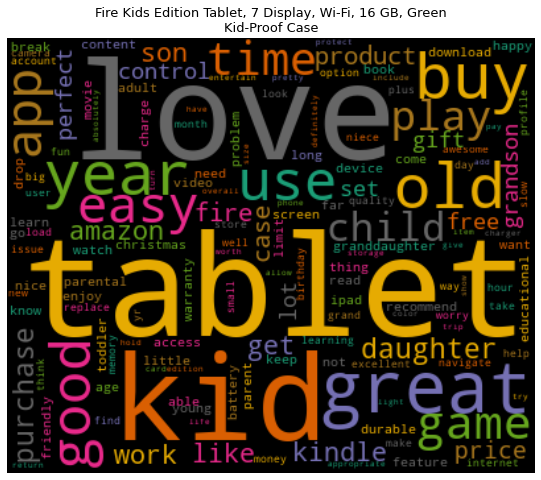

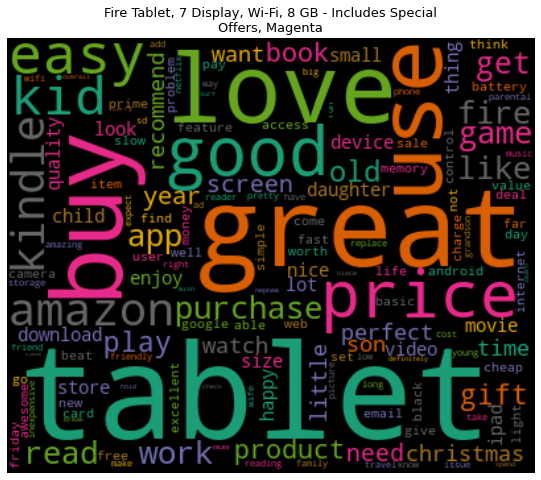

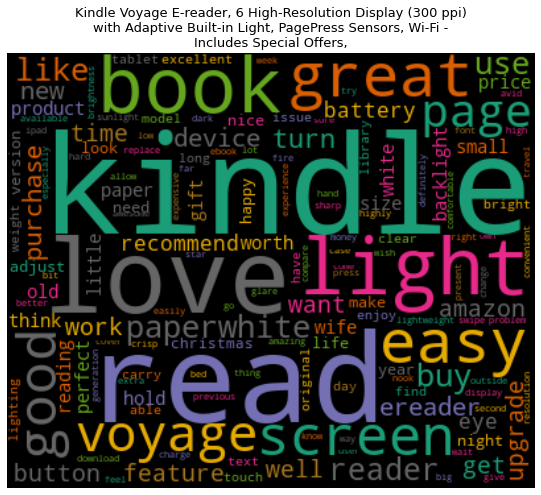

In [ ]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for each product
for index,product in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)

In [ ]:
from textblob import TextBlob
df['polarity']=df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [ ]:
print("3 Random Reviews with Highest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=False)[:3].index]['reviews.text']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Highest Polarity:
Review 1:
 This is an excellent product to give as a gift, one of the most reliable brands in the market.
Review 2:
 My Fire Kindle is wonderful and I use it all the time.
Review 3:
 Perfect for Home Automation and Wireless Entertainment.


In [ ]:
print("3 Random Reviews with Lowest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=True)[:3].index]['reviews.text']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Lowest Polarity:
Review 1:
 Bought it so my son would stop grabbing for my phone. Does what it needs to but battery life is horrible
Review 2:
 Reason I would not give it a full five stars is because of the fact that is so loaded down with adware for Amazon but an awful lot of that is what makes it affordable so $49 cannot beat it
Review 3:
 I really like the Paperwhite, it made me want to read books on my Kindle again. Try it if you hate it, return it, but get your hands on this for a while, and I am convinced you will keep it.


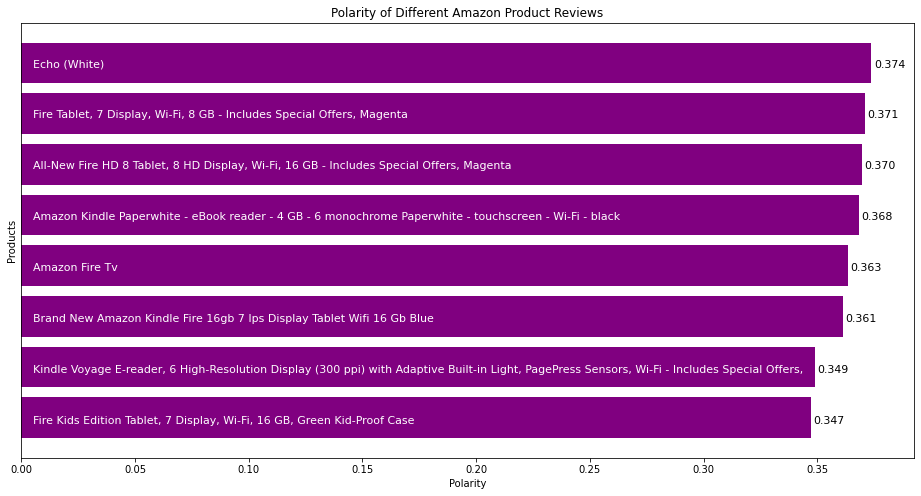

In [ ]:
product_polarity_sorted=pd.DataFrame(df.groupby('name')['polarity'].mean().sort_values(ascending=True))

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Products')
plt.title('Polarity of Different Amazon Product Reviews')
polarity_graph=plt.barh(np.arange(len(product_polarity_sorted.index)),product_polarity_sorted['polarity'],color='purple',)

# Writing product names on bar
for bar,product in zip(polarity_graph,product_polarity_sorted.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,product_polarity_sorted['polarity']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()

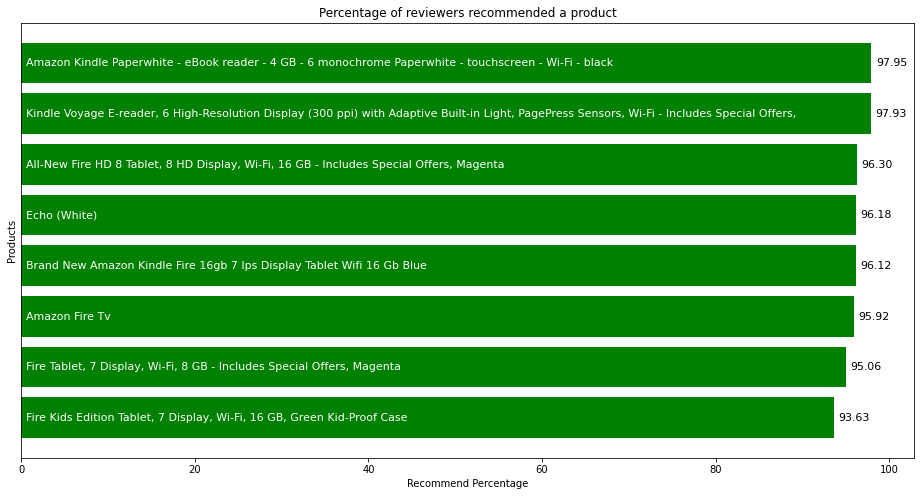

In [ ]:
recommend_percentage=pd.DataFrame(((df.groupby('name')['reviews.doRecommend'].sum()*100)/df.groupby('name')['reviews.doRecommend'].count()).sort_values(ascending=True))

plt.figure(figsize=(16,8))
plt.xlabel('Recommend Percentage')
plt.ylabel('Products')
plt.title('Percentage of reviewers recommended a product')
recommend_graph=plt.barh(np.arange(len(recommend_percentage.index)),recommend_percentage['reviews.doRecommend'],color='green')

# Writing product names on bar
for bar,product in zip(recommend_graph,recommend_percentage.index):
  plt.text(0.5,bar.get_y()+0.4,'{}'.format(product),va='center',fontsize=11,color='white')

# Writing recommendation percentage on graph
for bar,percentage in zip(recommend_graph,recommend_percentage['reviews.doRecommend']):
  plt.text(bar.get_width()+0.5,bar.get_y()+0.4,'%.2f'%percentage,va='center',fontsize=11,color='black')

plt.yticks([])
plt.show()

In [ ]:
import textstat
df['dale_chall_score']=df['reviews.text'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['flesh_reading_ease']=df['reviews.text'].apply(lambda x: textstat.flesch_reading_ease(x))
df['gunning_fog']=df['reviews.text'].apply(lambda x: textstat.gunning_fog(x))

print('Dale Chall Score of upvoted reviews=>',df[df['reviews.numHelpful']>1]['dale_chall_score'].mean())
print('Dale Chall Score of not upvoted reviews=>',df[df['reviews.numHelpful']<=1]['dale_chall_score'].mean())

print('Flesch Reading Score of upvoted reviews=>',df[df['reviews.numHelpful']>1]['flesh_reading_ease'].mean())
print('Flesch Reading Score of not upvoted reviews=>',df[df['reviews.numHelpful']<=1]['flesh_reading_ease'].mean())

print('Gunning Fog Index of upvoted reviews=>',df[df['reviews.numHelpful']>1]['gunning_fog'].mean())
print('Gunning Fog Index of not upvoted reviews=>',df[df['reviews.numHelpful']<=1]['gunning_fog'].mean())

ModuleNotFoundError: ignored

In [ ]:
df['text_standard']=df['reviews.text'].apply(lambda x: textstat.text_standard(x))

print('Text Standard of upvoted reviews=>',df[df['reviews.numHelpful']>1]['text_standard'].mode())
print('Text Standard of not upvoted reviews=>',df[df['reviews.numHelpful']<=1]['text_standard'].mode())

NameError: ignored

In [ ]:
df['text_standard']=df['reviews.text'].apply(lambda x: textstat.text_standard(x))

print('Text Standard of upvoted reviews=>',df[df['reviews.numHelpful']>1]['text_standard'].mode())
print('Text Standard of not upvoted reviews=>',df[df['reviews.numHelpful']<=1]['text_standard'].mode())

NameError: ignored

# **Sentiment Analysis of Amazon Reviews**

In [ ]:
data1 = pd.read_csv('/content/1429_1.csv')
data1.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

In [ ]:
data1['reviews.rating'].value_counts()

5.0    23775
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: reviews.rating, dtype: int64

In [ ]:
data2 = pd.read_csv("/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
data2 = data2[['reviews.rating' , 'reviews.text']]
data2 = data2[data2["reviews.rating"]<=3]

data3 = pd.read_csv("/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
data3 = data3[['reviews.rating' , 'reviews.text']]

In [ ]:
data2['reviews.rating'].value_counts()

3    1206
1     965
2     616
Name: reviews.rating, dtype: int64

In [ ]:
data3['reviews.rating'].value_counts()

5    3478
4    1208
3     197
1      63
2      54
Name: reviews.rating, dtype: int64

In [ ]:
data2 = data2[data2["reviews.rating"]<=3]
data3 = data3[data3["reviews.rating"]<=3]

In [ ]:
data=pd.concat([data1, data2, data3])

In [ ]:
d=pd.concat([data['reviews.text'],data['reviews.rating']], axis=1)
d.head()

,reviews.text,reviews.rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0


In [ ]:
d

,reviews.text,reviews.rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0
...,...,...
4904,The battery is having more and more trouble ho...,2.0
4945,My daughter has had this tablet for almost 2 m...,3.0
4953,Very cheap and was not impressed at all never ...,1.0
4971,"Hard to use, Lots of ads, and Randomly closes ...",2.0


In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37761 entries, 0 to 4975
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.text    37760 non-null  object 
 1   reviews.rating  37728 non-null  float64
dtypes: float64(1), object(1)
memory usage: 885.0+ KB


In [ ]:
d['reviews.rating'].value_counts()

5.0    23775
4.0     8541
3.0     2902
1.0     1438
2.0     1072
Name: reviews.rating, dtype: int64

In [ ]:
d.dropna(inplace=True)

In [ ]:
d=d.reset_index()

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37727 entries, 0 to 37726
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           37727 non-null  int64  
 1   reviews.text    37727 non-null  object 
 2   reviews.rating  37727 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 884.4+ KB


In [ ]:
d

,index,reviews.text,reviews.rating
0,0,This product so far has not disappointed. My c...,5.0
1,1,great for beginner or experienced person. Boug...,5.0
2,2,Inexpensive tablet for him to use and learn on...,5.0
3,3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,4,I bought this for my grand daughter when she c...,5.0
...,...,...,...
37722,4904,The battery is having more and more trouble ho...,2.0
37723,4945,My daughter has had this tablet for almost 2 m...,3.0
37724,4953,Very cheap and was not impressed at all never ...,1.0
37725,4971,"Hard to use, Lots of ads, and Randomly closes ...",2.0


In [ ]:
d.drop(columns=['index'],inplace=True)

In [ ]:
d

,reviews.text,reviews.rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0
...,...,...
37722,The battery is having more and more trouble ho...,2.0
37723,My daughter has had this tablet for almost 2 m...,3.0
37724,Very cheap and was not impressed at all never ...,1.0
37725,"Hard to use, Lots of ads, and Randomly closes ...",2.0


In [ ]:
d['reviews.rating'].value_counts()

5.0    23774
4.0     8541
3.0     2902
1.0     1438
2.0     1072
Name: reviews.rating, dtype: int64

# Data Preprocessing

In [ ]:
sentiment = {1: 0,
            2: 0,
            3: 0,
            4: 1,
            5: 1}
d['sentiment']=d['reviews.rating'].map(sentiment)

In [ ]:
d['sentiment'].value_counts()

1    32315
0     5412
Name: sentiment, dtype: int64

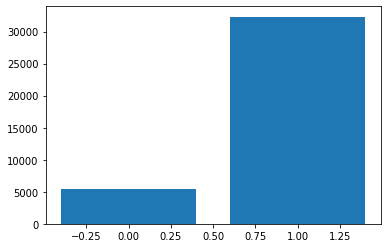

In [ ]:
counts=d['sentiment'].value_counts()
plt.bar(counts.index, counts.values)
plt.show()

In [ ]:
d[d['reviews.rating']==4]['reviews.text']

3        I've had my Fire HD 8 two weeks now and I love...
6        Great for e-reading on the go, nice and light ...
10       Not easy for elderly users cease of ads that p...
12       Wanted my father to have his first tablet and ...
16       nice reader. almost perfect for what i want/ne...
                               ...                        
34589    I was looking for ways to cut cost from a rais...
34590    I enjoy my kindle tv, it beats paying for cabl...
34593    Hey Alexa, Hey Alexa - Night and day it's Hey ...
34596    My new Kindle DX2 graphite came yesterday and ...
34607    Amazon already includes this cable with the Ki...
Name: reviews.text, Length: 8541, dtype: object

In [ ]:
list(d[d['reviews.rating']==3]['reviews.text'])[0:5]

['I was hoping to use Google launcher with this tablet but it is really locked down and you cannot change the launcher or the lock screen. Still cheap and fine for watching movies.',
 'The tablet works fine. It is responsive with good resolution. It is too tied to Amazon. It requires too many hoops to get apps such as Zinio to work. Until Amazon loosens its grip, I recommend only at a very good price.',
 "Fine for reading, ...haven't used it for anything else yet",
 'Though I have got it for cheap price during black friday, this Fire is not that great. Very bad camera and dim screen resolution. Pros:Install Google Play without any hassleVery good book reading option',
 "This is a good product for video, surfing and reading. However this version has dropped all android support as far as I can tell. I have a couple of apps that run on my old Fire just fine but are extremely problematic on this one. There is one app I use everyday but it doesn't work on this new Fire, so I have to keep th

Most Used words for both classes

In [ ]:
words = pd.Series(' '.join(df['reviews.text']).split())

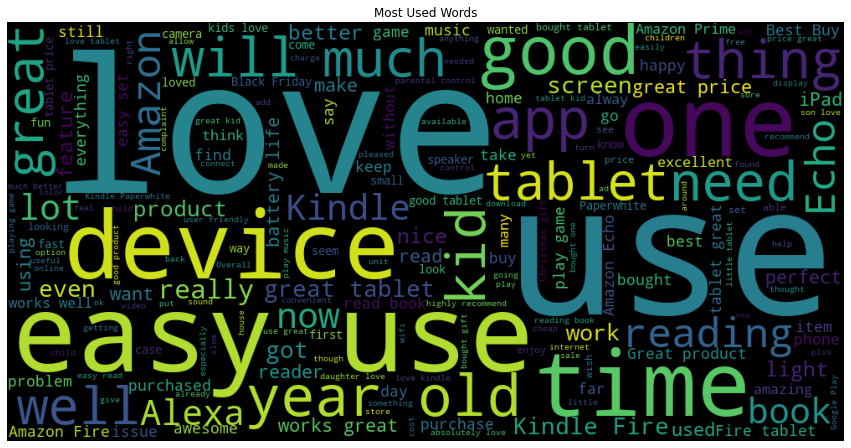

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Most Used Words")
plt.axis("off")
plt.show()


Positive Class

In [ ]:
positiveWords=words = pd.Series(' '.join(d[d['sentiment']==1]['reviews.text']).split())

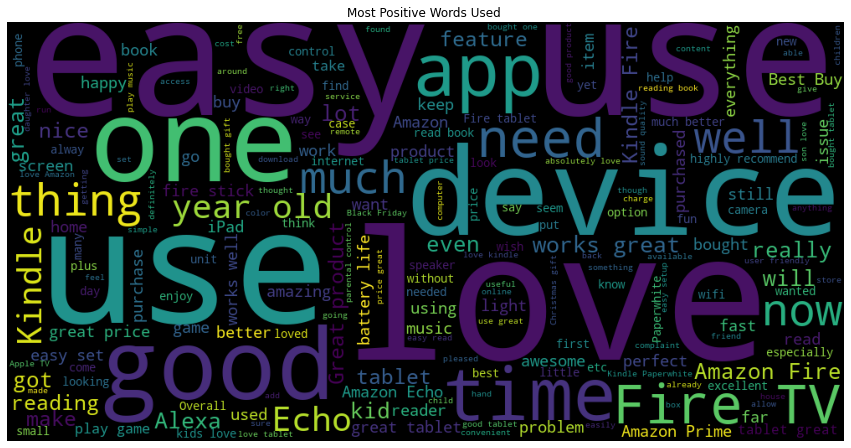

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(positiveWords))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Most Positive Words Used ")
plt.axis("off")
plt.show()

Negative Class

In [ ]:
negativeWords=words = pd.Series(' '.join(d[d['sentiment']==0]['reviews.text']).split())

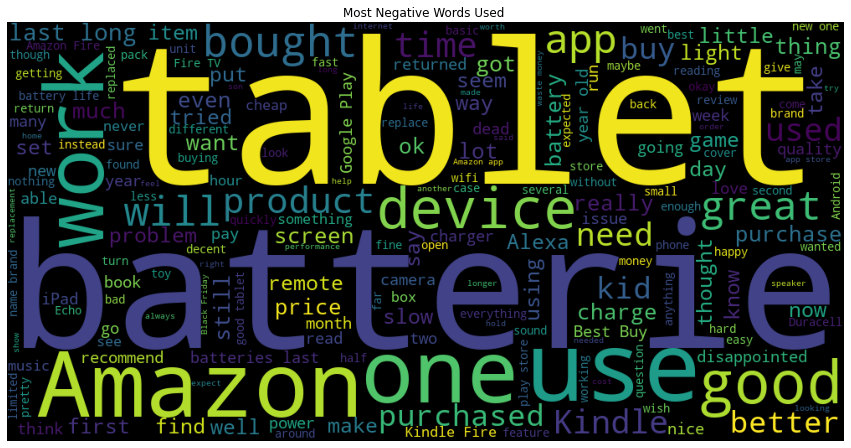

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negativeWords))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Most Negative Words Used ")
plt.axis("off")
plt.show()


## Natural Language Processing
# Text Preprocessing
Clean Text


In [ ]:
def cleanString(text):
    text = text.lower()
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(' \d+', ' ', text)
    return text
cleanString('This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.')

'this product so far has not disappointed my children love to use it and i like the ability to monitor control what content they see with ease '

In [ ]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopword_list = stopwords.words('english')
suitable_stopwords=[]
l =["n'",'nor','no','not']
for i in stopword_list:
    if not any(word in i for word in l):
        suitable_stopwords.append(i)
print(stopword_list)
print(suitable_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
suitable_stopwords=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
                    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
                    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
                    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
                    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
                    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because',
                    'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
                    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
                    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where',
                    'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only',
                    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'should', "should've",
                    'd', 'll', 'ma', 'm', 'o', 're', 've', 'y']
replace_list=['ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'mightn', 'mustn', 'needn',
              'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn',"n't","n'"]


Remove Stopwords

In [ ]:
def remove_stopwords(stmt):
    filtered_sentence = []
    words = word_tokenize(stmt)
    
    for w in words:
        if w not in suitable_stopwords:
            if w not in replace_list:
                filtered_sentence.append(w)
            else:
                filtered_sentence.append('not')
    return " ".join(filtered_sentence)
remove_stopwords('this product so far has not disappointed my children love to use it and i like the ability to monitor control what content they see with ease ')

'product far not disappointed children love use like ability monitor control content see ease'


Lemmatize Text

In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:

# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemmatize(text):
    # Initialize the lemmatizer
    wl = WordNetLemmatizer()
    lemmatized_sentence = []
    # Tokenize the sentence
    words = word_tokenize(text)
    # Get position tags
    word_pos_tags = nltk.pos_tag(words)
    # Map the position tag and lemmatize the word/token
    for idx, tag in enumerate(word_pos_tags):
        lemmatized_sentence.append(wl.lemmatize(tag[0], get_wordnet_pos(tag[1])))

    return " ".join(lemmatized_sentence)
    
lemmatize('product far not disappointed children love use like ability monitor control content see ease')

'product far not disappointed child love use like ability monitor control content see ease'

In [ ]:
d['text']=d['reviews.text'].apply(cleanString)

In [ ]:
d['text']=d['text'].apply(remove_stopwords)

In [ ]:
d['text']=d['text'].apply(lemmatize)

In [ ]:
d['reviews.text'].iloc[0]

'This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.'

In [ ]:
d['text'].iloc[0]

'product far not disappointed child love use like ability monitor control content see ease'


# Feature Engineering and Selection
Create TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features=700)
vectorizer.fit(d['text'])
features = vectorizer.transform(d['text'])

features.toarray()

array([[0.351511, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

In [ ]:
d.iloc[0]

reviews.text      This product so far has not disappointed. My c...
reviews.rating                                                    5
sentiment                                                         1
text              product far not disappointed child love use li...
Name: 0, dtype: object

In [ ]:
tf_idf = pd.DataFrame(features.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
tf_idf.head()

,ability,able,absolutely,access,account,actually,ad,add,addition,additional,adjust,adult,advertise,affordable,age,ago,alarm,alexa,allow,almost,along,alot,already,also,alternative,although,always,amaze,amazing,amazon,amount,android,annoy,another,answer,anyone,anything,anywhere,app,apple,...,video,videos,view,voice,volume,voyage,vue,wait,want,warranty,waste,watch,way,weather,web,week,weight,well,white,whole,wi,wife,wifi,wireless,wish,within,without,wonderful,word,work,worry,worth,would,wrong,year,yes,yet,young,youtube,yr
0,0.351511,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363932,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.128464,0.0,0.145339,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.170179,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.121908,0.0,0.0,0.0,0.14953,0.0,0.096488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.143334,0.0,0.0,0.0,0.0,0.0,0.187616,0.0,0.0,0.0,0.0,0.327014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.11102,0.0,0.0,0.0,0.0,0.000000,0.085642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tf_idf.iloc[0]['ease']

0.3583056382408408

# Splitting Dataset into Train and Test Set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf, d['sentiment'], test_size=0.2, random_state=42)

In [ ]:
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(30181, 700)
Test Set Shape		:(7546, 700)


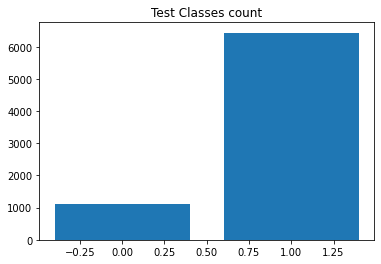

In [ ]:
counts=y_test.value_counts()
plt.title("Test Classes count")
plt.bar(counts.index, counts.values)
plt.show()

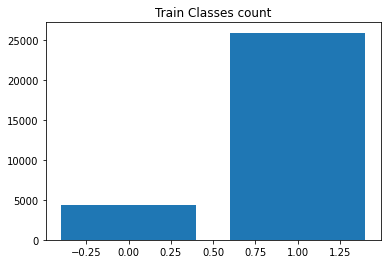

In [ ]:
counts=y_train.value_counts()
plt.title("Train Classes count")
plt.bar(counts.index, counts.values)
plt.show()

In [ ]:
yy=pd.DataFrame(y_train)

In [ ]:
train_data = pd.concat([X_train,yy],axis=1)

In [ ]:
train_data.head()

,ability,able,absolutely,access,account,actually,ad,add,addition,additional,adjust,adult,advertise,affordable,age,ago,alarm,alexa,allow,almost,along,alot,already,also,alternative,although,always,amaze,amazing,amazon,amount,android,annoy,another,answer,anyone,anything,anywhere,app,apple,...,videos,view,voice,volume,voyage,vue,wait,want,warranty,waste,watch,way,weather,web,week,weight,well,white,whole,wi,wife,wifi,wireless,wish,within,without,wonderful,word,work,worry,worth,would,wrong,year,yes,yet,young,youtube,yr,sentiment
25313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.414432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
21503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.264457,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
35729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
15266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.268628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Oversampling

In [ ]:
target_count = train_data['sentiment'].value_counts()
negative_class = train_data[train_data['sentiment'] == 0]
positive_class = train_data[train_data['sentiment'] == 1]
negative_over = negative_class.sample(target_count[1], replace=True)
df_train_over = pd.concat([positive_class, negative_over], axis=0)
df_train_over = shuffle(df_train_over)
df_train_over.head()

,ability,able,absolutely,access,account,actually,ad,add,addition,additional,adjust,adult,advertise,affordable,age,ago,alarm,alexa,allow,almost,along,alot,already,also,alternative,although,always,amaze,amazing,amazon,amount,android,annoy,another,answer,anyone,anything,anywhere,app,apple,...,videos,view,voice,volume,voyage,vue,wait,want,warranty,waste,watch,way,weather,web,week,weight,well,white,whole,wi,wife,wifi,wireless,wish,within,without,wonderful,word,work,worry,worth,would,wrong,year,yes,yet,young,youtube,yr,sentiment
24947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.460933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
12381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.622863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
23663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22351,0.0,0.0,0.0,0.0,0.0,0.395573,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
33981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.330948,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
30202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
df_train_over['sentiment'].value_counts()

1    25875
0    25875
Name: sentiment, dtype: int64

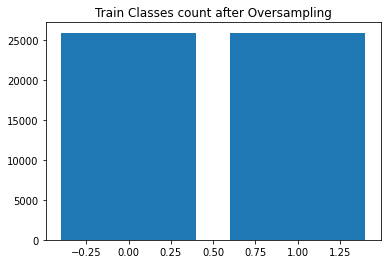

In [ ]:
counts=df_train_over['sentiment'].value_counts()
plt.title("Train Classes count after Oversampling")
plt.bar(counts.index, counts.values)
plt.show()

In [ ]:
X_train=df_train_over.iloc[:,:-1]
y_train=df_train_over['sentiment']

# Modeling

In [ ]:
def modeling(Model, Xtrain = X_train, Xtest = X_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    print(classification_report(y_test, y_pred))
    print ('AUC ',roc_auc_score(y_test, y_pred))
    #cm = confusion_matrix(y_test, y_pred)
    confusion_matrix = pd.crosstab(index=y_test, columns=np.round(y_pred), rownames=['True'], colnames=['predictions']).astype(int)
    plt.figure(figsize = (8,8))

    '''
    cmapGR = LinearSegmentedColormap.from_list(
        name='test', 
        colors=['red','green']
    )
    '''
    sns.heatmap(confusion_matrix, annot=True,annot_kws={"fontsize":12}, fmt='.2f', cmap='YlGnBu').set_title('Confusion Matrix') 

1.Naive Bayes

              precision    recall  f1-score   support

           0       0.48      0.83      0.61      1106
           1       0.97      0.84      0.90      6440

    accuracy                           0.84      7546
   macro avg       0.72      0.84      0.75      7546
weighted avg       0.89      0.84      0.86      7546

AUC  0.836387491154965


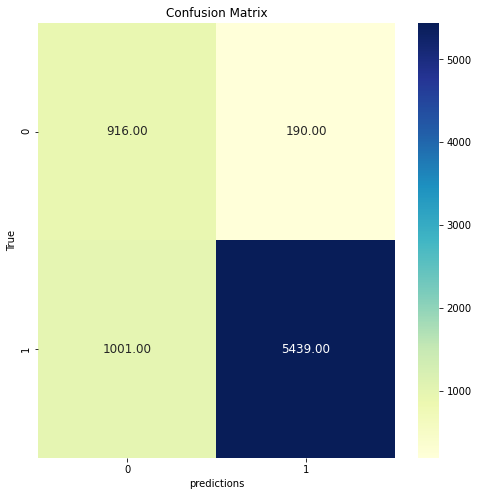

In [ ]:
modeling(MultinomialNB())

2.XGBoost

              precision    recall  f1-score   support

           0       0.44      0.83      0.57      1106
           1       0.97      0.82      0.89      6440

    accuracy                           0.82      7546
   macro avg       0.70      0.82      0.73      7546
weighted avg       0.89      0.82      0.84      7546

AUC  0.8245312131456876


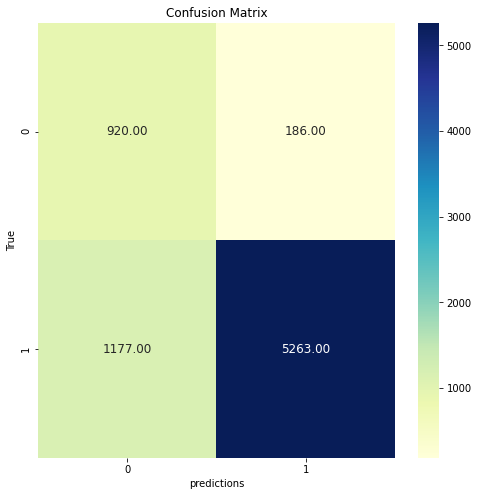

In [ ]:
modeling(XGBClassifier());